In [1]:
!nvidia-smi

Thu Apr 10 18:47:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
# Necessary libraries

import random
import numpy as np
import torch
import torch.nn as nn
import gdown # to download (ready) preprocessed dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, Subset,TensorDataset
from sklearn.model_selection import KFold
import os
import time  

In [3]:
# for reproducablity 

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
# Helper functions

def accumulate_episodes(data, signal_type):
    """
    Accumulate episodes from all records into a single dataset, ensuring uniform length.

    Parameters:
    - data (dict): Filtered dataset (e.g., butterworth_data).
    - signal_type (str): Type of signal to accumulate ('filtered_ecg' or 'filtered_abp').

    Returns:
    - accumulated_data (np.array): Array of shape (total_episodes, 625).
    """
    accumulated_data = []

    for record_id in data.keys():  # Loop through each record
        for episode in data[record_id][signal_type]:  # Loop through each 10-second episode
            if len(episode) == 625:  # Ensure the episode has 625 points
                accumulated_data.append(episode)  # Add the episode to the list
            #else:
                #print(f"Skipping episode with invalid length: {len(episode)} (Record: {record_id})")

    return np.array(accumulated_data)  # Convert list to numpy array


def extract_sbp_dbp(Ytrue, Ypred):
    """
    Calculate MAE, RMSE, ME±SD, and BHS Grade for SBP, DBP, and MAP.
    
    :param Ytrue: 2D array of ground truth ABP waveforms (shape: [n_samples, time_steps]).
    :param Ypred: 2D array of predicted ABP waveforms (shape: [n_samples, time_steps]).
    :return: Dictionary with calculated metrics.
    """

    # Initialize lists to store SBP, DBP, and MAP for true and predicted values
    sbp_true, sbp_pred = [], []
    dbp_true, dbp_pred = [], []
    

    for i in range(len(Ytrue)):
        y_t = Ytrue[i].ravel()
        y_p = Ypred[i].ravel()

        # Extract SBP (max), DBP (min), and MAP (mean)
        sbp_true.append(max(y_t))
        sbp_pred.append(max(y_p))
        dbp_true.append(min(y_t))
        dbp_pred.append(min(y_p))

        #print(f"  True SBP: {max(y_t):.2f}, Pred SBP: {max(y_p):.2f}, Error: {max(y_p) - max(y_t):.2f}")
        #print(f"  True DBP: {min(y_t):.2f}, Pred DBP: {min(y_p):.2f}, Error: {min(y_p) - min(y_t):.2f}")
        

    # Convert lists to numpy arrays
    sbp_true, sbp_pred = np.array(sbp_true), np.array(sbp_pred)
    dbp_true, dbp_pred = np.array(dbp_true), np.array(dbp_pred)
    
    return sbp_true, sbp_pred, dbp_true, dbp_pred

def bhs_grades(errors):
    """
    Compute BHS grading based on SBP/DBP errors.
    :param errors: Array of absolute errors (SBP or DBP).
    :return: Tuple of percentages (within_5, within_10, within_15) and BHS grade.
    """
    errors = np.abs(np.array(errors).flatten())
    within_5 = np.mean(errors <= 5) * 100
    within_10 = np.mean(errors <= 10) * 100
    within_15 = np.mean(errors <= 15) * 100

    if within_5 >= 60 and within_10 >= 85 and within_15 >= 95:
        grade = "A"
    elif within_5 >= 50 and within_10 >= 75 and within_15 >= 90:
        grade = "B"
    elif within_5 >= 40 and within_10 >= 65 and within_15 >= 85:
        grade = "C"
    else:
        grade = "Fail"

    return within_5, within_10, within_15, grade  # Return instead of printing

def calculate_error_metrics(y_true, y_pred):
    """
    Calculate MAE, RMSE, and ME ± SD for SBP and DBP.
    :param y_true: 1D array of true values (SBP or DBP).
    :param y_pred: 1D array of predicted values (SBP or DBP).
    :return: MAE, RMSE, ME ± SD (Mean Error and Standard Deviation of error).
    """

    y_true = np.array(y_true)  # Convert to NumPy array
    y_pred = np.array(y_pred)  # Convert to NumPy array

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_error = np.mean(y_pred - y_true)
    std_error = np.std(y_pred - y_true)

    return mae, rmse, mean_error, std_error


def compute_bp_metrics(file_prefix, num_folds, scaler):
    """
    Compute MAE, RMSE, ME±SD, and BHS Grades for MAP, SBP, and DBP across multiple folds.

    :param file_prefix: String, either "train" or "val" to indicate dataset type.
    :param num_folds: Integer, number of folds.
    :param scaler: Pretrained MinMaxScaler to inverse transform predictions.
    :return: Dictionary with all computed metrics.
    """

    # Initialize lists for storing errors
    mae_map_list, mse_map_list, me_map_list, sd_map_list = [], [], [], []
    mae_sbp_list, mse_sbp_list, me_sbp_list, sd_sbp_list = [], [], [], []
    mae_dbp_list, mse_dbp_list, me_dbp_list, sd_dbp_list = [], [], [], []

    # Initialize lists for storing BHS grades
    bhs_map_list, bhs_sbp_list, bhs_dbp_list = [], [], []

    # Process each fold efficiently
    for fold in range(1, num_folds + 1):
        print(f"Processing {file_prefix.capitalize()} Fold {fold}")

        # Memory-efficient loading
        preds = np.load(f"bp_cv-bm/{file_prefix}_preds_fold{fold}.npy", mmap_mode="r")
        targets = np.load(f"bp_cv-bm/{file_prefix}_targets_fold{fold}.npy", mmap_mode="r")

        # Inverse transform
        preds_original = scaler.inverse_transform(preds.reshape(-1, 1))
        targets_original = scaler.inverse_transform(targets.reshape(-1, 1))

        # Compute MAP (mean of ABP waveform)
        mae_map, rmse_map, me_map, sd_map = calculate_error_metrics(targets_original, preds_original)
        mae_map_list.append(mae_map)
        mse_map_list.append(rmse_map**2)  # Store MSE
        me_map_list.append(me_map)
        sd_map_list.append(sd_map)

        # Compute BHS grading for MAP
        bhs_map_list.append(bhs_grades(preds_original - targets_original))

        # Extract SBP and DBP from waveforms
        sbp_true, sbp_pred, dbp_true, dbp_pred = extract_sbp_dbp(targets, preds)

        # Compute SBP errors
        mae_sbp, rmse_sbp, me_sbp, sd_sbp = calculate_error_metrics(sbp_true, sbp_pred)
        mae_sbp_list.append(mae_sbp)
        mse_sbp_list.append(rmse_sbp**2)
        me_sbp_list.append(me_sbp)
        sd_sbp_list.append(sd_sbp)
        bhs_sbp_list.append(bhs_grades(sbp_pred - sbp_true))

        # Compute DBP errors
        mae_dbp, rmse_dbp, me_dbp, sd_dbp = calculate_error_metrics(dbp_true, dbp_pred)
        mae_dbp_list.append(mae_dbp)
        mse_dbp_list.append(rmse_dbp**2)
        me_dbp_list.append(me_dbp)
        sd_dbp_list.append(sd_dbp)
        bhs_dbp_list.append(bhs_grades(dbp_pred - dbp_true))

    # Compute final averages across all folds
    results = {
        "MAP": {
            "MAE": np.mean(mae_map_list),
            "RMSE": np.sqrt(np.mean(mse_map_list)),
            "ME ± SD": (np.mean(me_map_list), np.mean(sd_map_list)),
            "BHS": np.mean(np.array([bhs[:3] for bhs in bhs_map_list]), axis=0)
        },
        "SBP": {
            "MAE": np.mean(mae_sbp_list),
            "RMSE": np.sqrt(np.mean(mse_sbp_list)),
            "ME ± SD": (np.mean(me_sbp_list), np.mean(sd_sbp_list)),
            "BHS": np.mean(np.array([bhs[:3] for bhs in bhs_sbp_list]), axis=0)
        },
        "DBP": {
            "MAE": np.mean(mae_dbp_list),
            "RMSE": np.sqrt(np.mean(mse_dbp_list)),
            "ME ± SD": (np.mean(me_dbp_list), np.mean(sd_dbp_list)),
            "BHS": np.mean(np.array([bhs[:3] for bhs in bhs_dbp_list]), axis=0)
        }
    }

    return results

def print_metrics(metrics, title):
    """
    Print computed metrics in a readable format.

    :param metrics: Dictionary containing MAP, SBP, DBP metrics.
    :param title: String, title for the section.
    """
    print("\n" + "=" * 50)
    print(f"{title} ")
    print("=" * 50)

    for key, values in metrics.items():
        print(f"\n {key} Metrics:")
        print(f"    MAE:  {values['MAE']:.4f}")
        print(f"    RMSE: {values['RMSE']:.4f}")
        print(f"    ME ± SD: {values['ME ± SD'][0]:.4f} ± {values['ME ± SD'][1]:.4f}")
        print(f"    BHS Grades: {values['BHS']}")

In [5]:
# BP-Net architecture

class IncBlock(nn.Module):
    def __init__(self, in_channels, out_channels, size=15, stride=1, padding=7):
        super(IncBlock, self).__init__()

        self.conv1x1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)

        self.conv1 = nn.Sequential(nn.Conv1d(in_channels, out_channels // 4, kernel_size=size, stride=stride, padding=padding),
                                   nn.BatchNorm1d(out_channels // 4))

        self.conv2 = nn.Sequential(nn.Conv1d(in_channels, out_channels // 4, kernel_size=1, bias=False),
                                   nn.BatchNorm1d(out_channels // 4),
                                   nn.LeakyReLU(0.2),
                                   nn.Conv1d(out_channels // 4, out_channels // 4, kernel_size=size + 2, stride=stride, padding=padding + 1),
                                   nn.BatchNorm1d(out_channels // 4))

        self.conv3 = nn.Sequential(nn.Conv1d(in_channels, out_channels // 4, kernel_size=1, bias=False),
                                   nn.BatchNorm1d(out_channels // 4),
                                   nn.LeakyReLU(0.2),
                                   nn.Conv1d(out_channels // 4, out_channels // 4, kernel_size=size + 4, stride=stride, padding=padding + 2),
                                   nn.BatchNorm1d(out_channels // 4))

        self.conv4 = nn.Sequential(nn.Conv1d(in_channels, out_channels // 4, kernel_size=1, bias=False),
                                   nn.BatchNorm1d(out_channels // 4),
                                   nn.LeakyReLU(0.2),
                                   nn.Conv1d(out_channels // 4, out_channels // 4, kernel_size=size + 6, stride=stride, padding=padding + 3),
                                   nn.BatchNorm1d(out_channels // 4))
        self.relu = nn.ReLU()

    def forward(self, x):
        res = self.conv1x1(x)
        c1 = self.conv1(x)
        c2 = self.conv2(x)
        c3 = self.conv3(x)
        c4 = self.conv4(x)
        concat = torch.cat((c1, c2, c3, c4), dim=1)
        concat += res
        return self.relu(concat)

class InterAxialBlock(nn.Module):
    def __init__(self, in_channels=2, out_channels=1):
        super(InterAxialBlock, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(8)

        self.conv2 = nn.Conv1d(8, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(16)

        self.conv3 = nn.Conv1d(16, 1, 3, padding=1)
        self.bn3 = nn.BatchNorm1d(1)

        self.conv4 = nn.Conv1d(1, 1, 3, padding=7)
        self.bn4 = nn.BatchNorm1d(1)

        self.conv5 = nn.Conv1d(1, in_channels, 3, padding=1)
        self.bn5 = nn.BatchNorm1d(in_channels)
        self.relu1 = nn.LeakyReLU(0.2)

        self.mp1 = nn.MaxPool1d(2)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu1(self.bn2(self.conv2(x)))
        x = self.relu1(self.bn3(self.conv3(x)))
        x = self.mp1(x)
        x = self.relu1(self.bn4(self.conv4(x)))
        x = self.relu1(self.bn5(self.conv5(x)))
        return x

class Unet(nn.Module):
    def __init__(self, shape):
        super(Unet, self).__init__()
        in_channels = 1  # Input channels for PPG + ECG

        self.inter = nn.Sequential(InterAxialBlock(in_channels=in_channels))

        # Encoder
        self.en1 = nn.Sequential(
            nn.Conv1d(in_channels, 32, 3, padding=1),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            nn.Conv1d(32, 32, 5, stride=2, padding=2),
            IncBlock(32, 32)
        )

        self.en2 = nn.Sequential(
            nn.Conv1d(32, 64, 3, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 64, 5, stride=2, padding=2),
            IncBlock(64, 64)
        )

        self.en3 = nn.Sequential(
            nn.Conv1d(64, 128, 3, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 128, 3, stride=2, padding=1),
            IncBlock(128, 128)
        )

        self.en4 = nn.Sequential(
            nn.Conv1d(128, 256, 3, padding=1),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Conv1d(256, 256, 3, stride=2, padding=1),
            IncBlock(256, 256)
        )

        self.en5 = nn.Sequential(
            nn.Conv1d(256, 512, 3, padding=1),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            IncBlock(512, 512)
        )

        # Decoder
        self.de1 = nn.Sequential(
            nn.ConvTranspose1d(512, 256, 2, stride=2),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            IncBlock(256, 256)
        )

        self.de2 = nn.Sequential(
            nn.ConvTranspose1d(256, 128, 2, stride=2),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            IncBlock(128, 128)
        )

        self.de3 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, 2, stride=2),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            IncBlock(64, 64)
        )

        self.de4 = nn.Sequential(
            nn.ConvTranspose1d(64, 32, 2, stride=2),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            IncBlock(32, 32)
        )

        self.de5 = nn.Sequential(
            nn.ConvTranspose1d(32, 16, 2, stride=2),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2),
            IncBlock(16, 16)
        )

        # Final layer
        self.final_conv = nn.Conv1d(16, 1, kernel_size=7, padding=3)  # Output 1 channel for ABP

    def forward(self, x):
        x = self.inter(x)
        x1 = self.en1(x)
        x2 = self.en2(x1)
        x3 = self.en3(x2)
        x4 = self.en4(x3)
        x5 = self.en5(x4)

        x = self.de1(x5)
        x = self.de2(x)
        x = self.de3(x)
        x = self.de4(x)
        x = self.de5(x)

        # Final layer to get desired output shape
        x = self.final_conv(x)

        # Pad if necessary
        if x.size(2) < 625:
            x = nn.functional.pad(x, (0, 625 - x.size(2)))
        elif x.size(2) > 625:
            x = x[:, :, :625]

        return x

In [6]:
## Checking input - output shape

batch_size = 256  # Number of samples in a batch
channels = 1    # Number of input channels (e.g., single-channel signal)
length = 625   # Length of the input signal

# Create synthetic input tensor
input_tensor = torch.randn(batch_size, channels, length)

# Initialize the model
model = Unet(shape=(batch_size, channels, length))

# Perform a forward pass
output = model(input_tensor)

# Print input and output shapes
print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([256, 1, 625])
Output shape: torch.Size([256, 1, 625])


In [7]:
# Download dataset 

file_id = "12KmtjeVHuZP4omk-AvEBpfwmI1cPn1R7"
download_url = f"https://drive.google.com/uc?id={file_id}"
output_file = "butter_maf_dataset.npy"

gdown.download(download_url, output_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=12KmtjeVHuZP4omk-AvEBpfwmI1cPn1R7
From (redirected): https://drive.google.com/uc?id=12KmtjeVHuZP4omk-AvEBpfwmI1cPn1R7&confirm=t&uuid=3a7d3a3f-33aa-44c2-a2a8-3da6755850c6
To: /kaggle/working/butter_maf_dataset.npy
100%|██████████| 384M/384M [00:09<00:00, 41.3MB/s] 


'butter_maf_dataset.npy'

In [8]:
# Load the dataset 

bm_data = np.load("butter_maf_dataset.npy", allow_pickle=True).item()
ecg_bm = accumulate_episodes(bm_data, signal_type='filtered_ecg')
abp_bm = accumulate_episodes(bm_data, signal_type='filtered_abp')

print(f"Shapes of ECG: {ecg_bm.shape}")
print(f"Shapes of ABP: {abp_bm.shape}")

Shapes of ECG: (25319, 625)
Shapes of ABP: (25319, 625)


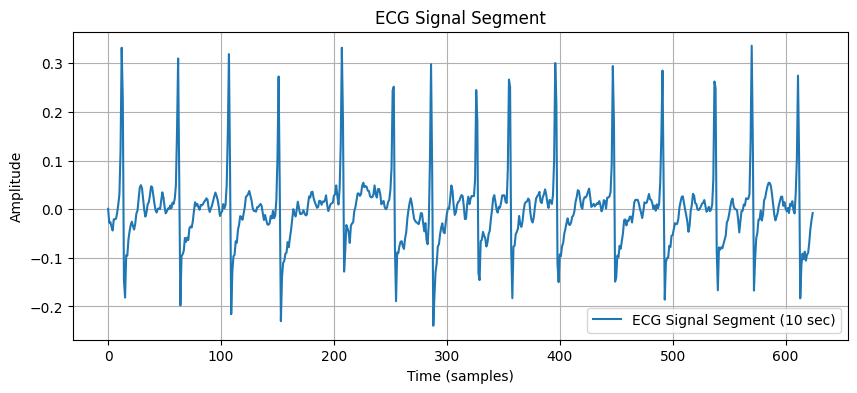

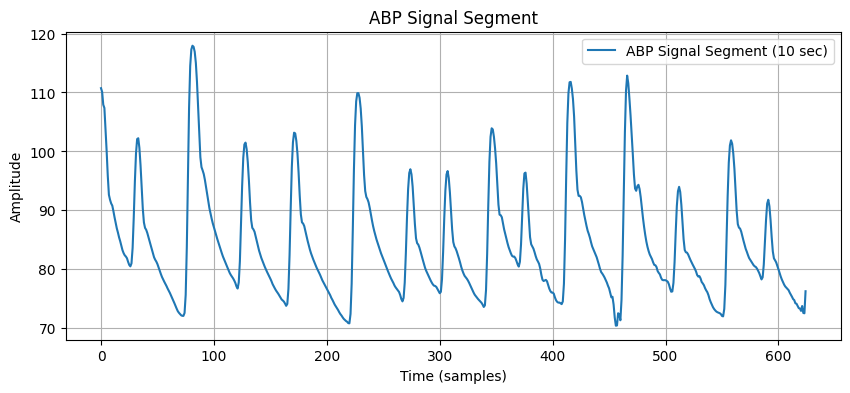

In [9]:
# Choose a specific episode (e.g., the first episode)
signal_segment_ecg = ecg_bm[0]
signal_segment_abp = abp_bm[0]

# Plot the signal
plt.figure(figsize=(10, 4))
plt.plot(signal_segment_ecg, label="ECG Signal Segment (10 sec)")
plt.title("ECG Signal Segment")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(signal_segment_abp, label="ABP Signal Segment (10 sec)")
plt.title("ABP Signal Segment")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Data preparation
# Split the dataset (80% train, 20% test)

train_ecg, test_ecg = train_test_split(ecg_bm, test_size=0.2, random_state=42)
train_abp, test_abp = train_test_split(abp_bm, test_size=0.2, random_state=42)

# Initialize MinMaxScaler
scaler_ecg = MinMaxScaler()
scaler_abp = MinMaxScaler()

# Fit the scaler only on the training set
scaler_ecg.fit(train_ecg.reshape(-1, 1))
scaler_abp.fit(train_abp.reshape(-1, 1))

# Transform both training and test sets using the fitted scaler
normalized_train_ecg = scaler_ecg.transform(train_ecg.reshape(-1, 1)).reshape(train_ecg.shape)
normalized_test_ecg = scaler_ecg.transform(test_ecg.reshape(-1, 1)).reshape(test_ecg.shape)

normalized_train_abp = scaler_abp.transform(train_abp.reshape(-1, 1)).reshape(train_abp.shape)
normalized_test_abp = scaler_abp.transform(test_abp.reshape(-1, 1)).reshape(test_abp.shape)

# Add a channel dimension (for PyTorch compatibility)
train_ecg_tensor = torch.tensor(normalized_train_ecg[:, np.newaxis, :], dtype=torch.float32)
test_ecg_tensor = torch.tensor(normalized_test_ecg[:, np.newaxis, :], dtype=torch.float32)

train_abp_tensor = torch.tensor(normalized_train_abp[:, np.newaxis, :], dtype=torch.float32)
test_abp_tensor = torch.tensor(normalized_test_abp[:, np.newaxis, :], dtype=torch.float32)

# Check the shape
print(f"Train ECG Tensor: {train_ecg_tensor.shape}, Test ECG Tensor: {test_ecg_tensor.shape}")
print(f"Train ABP Tensor: {train_abp_tensor.shape}, Test ABP Tensor: {test_abp_tensor.shape}")

Train ECG Tensor: torch.Size([20255, 1, 625]), Test ECG Tensor: torch.Size([5064, 1, 625])
Train ABP Tensor: torch.Size([20255, 1, 625]), Test ABP Tensor: torch.Size([5064, 1, 625])


### SSL Code, where model learns ECG-to-ECG

In [16]:
# Check if GPU is available, otherwise default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming ecg_tensor is already defined
target_tensor = train_ecg_tensor

# Convert your tensors into a TensorDataset and then wrap it with DataLoader
batch_size = 256  # Adjust this based on your GPU memory capacity or experiment settings
dataset = TensorDataset(train_ecg_tensor, target_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Step 2: Initialize the model, criterion, and optimizer
model = Unet(shape=(1, 625))  # Adjust shape parameters if needed
model.to(device)  # Move the model to GPU (or CPU if no GPU)

criterion = nn.MSELoss()  # Mean squared error for signal reconstruction
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Step 3: Training loop with batching
num_epochs = 100  # Example, adjust as needed

for epoch in range(num_epochs):
    start = time.time()
    model.train()

    epoch_loss = 0.0
    for batch_idx, (ecg_batch, target_batch) in enumerate(data_loader):
        # Move data to GPU (or CPU if no GPU)
        ecg_batch, target_batch = ecg_batch.to(device), target_batch.to(device)

        # Forward pass
        reconstructed_ecg = model(ecg_batch)

        # Compute loss
        loss = criterion(reconstructed_ecg, target_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
    total = time.time() - start
    # Print loss for the epoch
    avg_epoch_loss = epoch_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, Time: {total:.2f}")

Epoch [1/100], Loss: 0.1161, Time: 17.75
Epoch [2/100], Loss: 0.0015, Time: 17.73
Epoch [3/100], Loss: 0.0005, Time: 17.90
Epoch [4/100], Loss: 0.0004, Time: 17.71
Epoch [5/100], Loss: 0.0003, Time: 17.72
Epoch [6/100], Loss: 0.0003, Time: 17.75
Epoch [7/100], Loss: 0.0003, Time: 17.71
Epoch [8/100], Loss: 0.0003, Time: 17.75
Epoch [9/100], Loss: 0.0002, Time: 17.72
Epoch [10/100], Loss: 0.0002, Time: 17.71
Epoch [11/100], Loss: 0.0002, Time: 17.72
Epoch [12/100], Loss: 0.0002, Time: 17.71
Epoch [13/100], Loss: 0.0002, Time: 17.71
Epoch [14/100], Loss: 0.0002, Time: 17.73
Epoch [15/100], Loss: 0.0002, Time: 17.72
Epoch [16/100], Loss: 0.0002, Time: 17.72
Epoch [17/100], Loss: 0.0002, Time: 17.73
Epoch [18/100], Loss: 0.0002, Time: 17.73
Epoch [19/100], Loss: 0.0002, Time: 17.71
Epoch [20/100], Loss: 0.0002, Time: 17.72
Epoch [21/100], Loss: 0.0002, Time: 17.72
Epoch [22/100], Loss: 0.0002, Time: 17.72
Epoch [23/100], Loss: 0.0002, Time: 17.89
Epoch [24/100], Loss: 0.0002, Time: 17.72
E

In [18]:
torch.save(model.state_dict(), 'bp_net_ssl_weights.pth')

## Cross-validation

In [19]:
RESULTS_FOLDER = "bp_cv-bm"
os.makedirs(RESULTS_FOLDER, exist_ok=True)

def save_append_npy(file_name, new_data):
    """ Append new data to existing .npy file or create a new file. """
    file_path = os.path.join(RESULTS_FOLDER, file_name)
    if os.path.exists(file_path):
        existing_data = np.load(file_path, allow_pickle=True)
        updated_data = np.vstack((existing_data, new_data))
    else:
        updated_data = new_data
    np.save(file_path, updated_data)

def cross_validate_pytorch(train_dataset, n_splits=5, num_epochs=100, batch_size=256, lr=0.0001, seed=42, device='cuda'):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
        print(f"\nTraining fold {fold + 1}/{n_splits}...")

        train_subset = Subset(train_dataset, train_idx)
        val_subset = Subset(train_dataset, val_idx)
        
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model = Unet(shape=(1, 1250))
        model.load_state_dict(torch.load('bp_net_ssl_weights.pth', weights_only=True))
        model.to(device)

        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # **Initialize accumulation lists**
        accumulated_train_losses, accumulated_val_losses = [], []
        accumulated_train_preds, accumulated_train_targets = [], []
        accumulated_val_preds, accumulated_val_targets = [], []

        for epoch in range(num_epochs):
            start_time = time.time()  

            model.train()
            train_loss = 0.0
            train_preds, train_targets = [], []

            for ecg_batch, target_batch in train_loader:
                ecg_batch, target_batch = ecg_batch.to(device), target_batch.to(device)
                optimizer.zero_grad()
                output = model(ecg_batch)
                loss = criterion(output, target_batch)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_preds.extend(output.detach().cpu().numpy().flatten())
                train_targets.extend(target_batch.cpu().numpy().flatten())

            train_loss /= len(train_loader)

            # **Accumulate results**
            accumulated_train_losses.append(train_loss)
            accumulated_train_preds.extend(train_preds)
            accumulated_train_targets.extend(train_targets)

            model.eval()
            val_preds, val_targets = [], []
            val_loss = 0.0
            with torch.no_grad():
                for ecg_batch, target_batch in val_loader:
                    ecg_batch, target_batch = ecg_batch.to(device), target_batch.to(device)
                    output = model(ecg_batch)
                    loss = criterion(output, target_batch)
                    val_loss += loss.item()
                    
                    val_preds.extend(output.cpu().numpy().flatten())
                    val_targets.extend(target_batch.cpu().numpy().flatten())

            val_loss /= len(val_loader)

            # **Accumulate results**
            accumulated_val_losses.append(val_loss)
            accumulated_val_preds.extend(val_preds)
            accumulated_val_targets.extend(val_targets)

            epoch_time = time.time() - start_time  

            print(f" Fold {fold+1}/{n_splits} Epoch {epoch+1}: Train Loss = {train_loss:.5f}, Val Loss = {val_loss:.5f}, Time = {epoch_time:.2f} sec")

            # **Save every 10 epochs, but store mean values**
            if (epoch + 1) % 10 == 0:
                save_append_npy(f"train_preds_fold{fold+1}.npy", np.mean(accumulated_train_preds, axis=0, keepdims=True))
                save_append_npy(f"train_targets_fold{fold+1}.npy", np.mean(accumulated_train_targets, axis=0, keepdims=True))
                save_append_npy(f"train_loss_fold{fold+1}.npy", np.mean(accumulated_train_losses, keepdims=True))

                save_append_npy(f"val_preds_fold{fold+1}.npy", np.mean(accumulated_val_preds, axis=0, keepdims=True))
                save_append_npy(f"val_targets_fold{fold+1}.npy", np.mean(accumulated_val_targets, axis=0, keepdims=True))
                save_append_npy(f"val_loss_fold{fold+1}.npy", np.mean(accumulated_val_losses, keepdims=True))

                # **Clear accumulated lists**
                accumulated_train_losses, accumulated_val_losses = [], []
                accumulated_train_preds, accumulated_train_targets = [], []
                accumulated_val_preds, accumulated_val_targets = [], []

            torch.cuda.empty_cache()

    print("\nStored training and validation predictions and ground truth for future analysis.")


In [21]:
train_dataset = TensorDataset(train_ecg_tensor, train_abp_tensor)

start = time.time()
cross_validate_pytorch(train_dataset)
end = time.time()

elapsed_time = end - start
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(f"Total time taken: {hours}h {minutes}m {seconds}s")


Training fold 1/5...
 Fold 1/5 Epoch 1: Train Loss = 0.02298, Val Loss = 0.01168, Time = 17.58 sec
 Fold 1/5 Epoch 2: Train Loss = 0.00918, Val Loss = 0.00835, Time = 17.72 sec
 Fold 1/5 Epoch 3: Train Loss = 0.00680, Val Loss = 0.00652, Time = 17.80 sec
 Fold 1/5 Epoch 4: Train Loss = 0.00585, Val Loss = 0.00574, Time = 17.75 sec
 Fold 1/5 Epoch 5: Train Loss = 0.00519, Val Loss = 0.00554, Time = 17.73 sec
 Fold 1/5 Epoch 6: Train Loss = 0.00483, Val Loss = 0.00521, Time = 17.76 sec
 Fold 1/5 Epoch 7: Train Loss = 0.00443, Val Loss = 0.00497, Time = 17.71 sec
 Fold 1/5 Epoch 8: Train Loss = 0.00412, Val Loss = 0.00488, Time = 17.73 sec
 Fold 1/5 Epoch 9: Train Loss = 0.00389, Val Loss = 0.00468, Time = 17.71 sec
 Fold 1/5 Epoch 10: Train Loss = 0.00370, Val Loss = 0.00457, Time = 17.72 sec
 Fold 1/5 Epoch 11: Train Loss = 0.00347, Val Loss = 0.00511, Time = 18.02 sec
 Fold 1/5 Epoch 12: Train Loss = 0.00329, Val Loss = 0.00457, Time = 17.79 sec
 Fold 1/5 Epoch 13: Train Loss = 0.0030

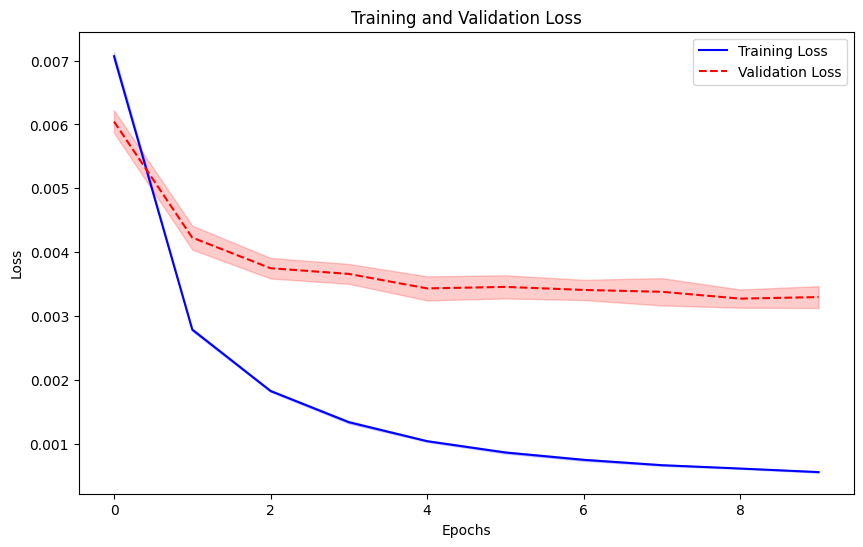

In [22]:
# Plot Training vs Validation curves across 5 folds (mean)

num_folds = 5
num_epochs = 100  # Ensure this matches your training setup

train_losses_folds = []
val_losses_folds = []

for fold in range(1, num_folds + 1):
    train_loss = np.load(f"bp_cv-bm/train_loss_fold{fold}.npy")  # Load training loss
    val_loss = np.load(f"bp_cv-bm/val_loss_fold{fold}.npy")  # Load validation loss
    
    train_losses_folds.append(train_loss)
    val_losses_folds.append(val_loss)

train_losses_folds = np.array(train_losses_folds)  # Shape: (num_folds, num_epochs)
val_losses_folds = np.array(val_losses_folds)  # Shape: (num_folds, num_epochs)

train_mean = np.mean(train_losses_folds, axis=0)
train_std = np.std(train_losses_folds, axis=0)
val_mean = np.mean(val_losses_folds, axis=0)
val_std = np.std(val_losses_folds, axis=0)

train_mean = np.array(train_mean).flatten()
train_std = np.array(train_std).flatten()
val_mean = np.array(val_mean).flatten()
val_std = np.array(val_std).flatten()

# Ensure the dimensions match `num_epochs`
epochs = np.arange(len(train_mean))

plt.figure(figsize=(10, 6))

# Plot training loss with confidence interval
plt.plot(epochs, train_mean, label='Training Loss', color='blue')
plt.fill_between(epochs, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

# Plot validation loss with confidence interval
plt.plot(epochs, val_mean, label='Validation Loss', linestyle='dashed', color='red')
plt.fill_between(epochs, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## Final Evaluation on 20% of data

In [ ]:
batch_size = 256

train_dataset = TensorDataset(train_ecg_tensor, train_abp_tensor)
test_dataset = TensorDataset(test_ecg_tensor, test_abp_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = Unet(shape=(1, 625))
model.load_state_dict(torch.load('bp_net_ssl_weights.pth', weights_only=True))
model.to(device)  # Move model to GPU/CPU

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Track training losses
train_losses = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    start_time = time.time()  # Start timing
    model.train()
    epoch_loss = 0.0

    for ecg_batch, target_batch in train_loader:
        ecg_batch, target_batch = ecg_batch.to(device), target_batch.to(device)

        optimizer.zero_grad()
        reconstructed_abp = model(ecg_batch)
        loss = criterion(reconstructed_abp, target_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_time = time.time() - start_time
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_loss:.4f}, Time: {epoch_time:.2f}")


model.eval()

# Store predictions and actual ABP values for evaluation
predictions = []
true_values = []

with torch.no_grad():  # No need to compute gradients during inference
    for batch_idx, (ecg_batch, abp_batch) in enumerate(test_loader):
        # Forward pass through the model
        predicted_abp = model(ecg_batch.to(device))  # Assuming model is on GPU

        # Move predictions and true values to CPU for scaling
        predicted_abp = predicted_abp.cpu().detach().numpy()
        abp_batch = abp_batch.cpu().detach().numpy()

        # Flatten the 3D array to 2D (if it's 3D) for scaler
        predicted_abp_flat = predicted_abp.reshape(-1, predicted_abp.shape[-1])  # Flatten to 2D
        abp_batch_flat = abp_batch.reshape(-1, abp_batch.shape[-1])  # Flatten to 2D

        # Inverse scale the predicted and true ABP values using MinMaxScaler
        predicted_abp_inv = scaler_abp.inverse_transform(predicted_abp_flat)
        true_values_inv = scaler_abp.inverse_transform(abp_batch_flat)

        # Append the results to lists (for evaluation later)
        predictions.append(predicted_abp_inv)
        true_values.append(true_values_inv)

# Convert the lists to numpy arrays for further evaluation
predictions = np.concatenate(predictions, axis=0)
true_values = np.concatenate(true_values, axis=0)

In [ ]:
# Error computation for continious blood pressure

abp_mae, abp_rmse, abp_me, abp_sd = calculate_error_metrics(true_values.flatten(), predictions.flatten())
abp_within_5, abp_within_10, abp_within_15, abp_grade = bhs_grades(predictions.flatten() - true_values.flatten())

print(f"ABP MAE: {abp_mae:.2f}, RMSE: {abp_rmse:.2f}, ME ± SD: {abp_me:.2f} ± {abp_sd:.2f}")
print(f"ABP BHS Grades: Within 5mmHg: {abp_within_5:.2f}%, Within 10mmHg: {abp_within_10:.2f}%, Within 15mmHg: {abp_within_15:.2f}%, Grade: {abp_grade}")


In [ ]:
ABP MAE: 1.95, RMSE: 3.35, ME ± SD: -0.07 ± 3.35
ABP BHS Grades: Within 5mmHg: 92.71%, Within 10mmHg: 98.40%, Within 15mmHg: 99.56%, Grade: A

In [ ]:
# Error computation for SBP and DBP

sbp_true, sbp_pred, dbp_true, dbp_pred = extract_sbp_dbp(true_values, predictions)

sbp_mae, sbp_rmse, sbp_me, sbp_sd = calculate_error_metrics(sbp_true, sbp_pred)
dbp_mae, dbp_rmse, dbp_me, dbp_sd = calculate_error_metrics(dbp_true, dbp_pred)

sbp_within_5, sbp_within_10, sbp_within_15, sbp_grade = bhs_grades(sbp_pred - sbp_true)
dbp_within_5, dbp_within_10, dbp_within_15, dbp_grade = bhs_grades(dbp_pred - dbp_true)

print(f"SBP MAE: {sbp_mae:.2f}, RMSE: {sbp_rmse:.2f}, ME ± SD: {sbp_me:.2f} ± {sbp_sd:.2f}")
print(f"DBP MAE: {dbp_mae:.2f}, RMSE: {dbp_rmse:.2f}, ME ± SD: {dbp_me:.2f} ± {dbp_sd:.2f}")

print(f"SBP BHS Grades: Within 5mmHg: {sbp_within_5:.2f}%, Within 10mmHg: {sbp_within_10:.2f}%, Within 15mmHg: {sbp_within_15:.2f}%, Grade: {sbp_grade}")
print(f"DBP BHS Grades: Within 5mmHg: {dbp_within_5:.2f}%, Within 10mmHg: {dbp_within_10:.2f}%, Within 15mmHg: {dbp_within_15:.2f}%, Grade: {dbp_grade}")


In [ ]:
SBP MAE: 1.80, RMSE: 10.89, ME ± SD: -0.05 ± 10.89
DBP MAE: 3.50, RMSE: 15.68, ME ± SD: -2.09 ± 15.54
SBP BHS Grades: Within 5mmHg: 98.54%, Within 10mmHg: 99.25%, Within 15mmHg: 99.57%, Grade: A
DBP BHS Grades: Within 5mmHg: 83.33%, Within 10mmHg: 88.39%, Within 15mmHg: 99.45%, Grade: A

In [ ]:
# Plot predicted vs true ABP 

# Plot the first test sample's true vs predicted ABP signal
plt.figure(figsize=(12, 6))

# Inverse scaled true and predicted ABP signals for the first sample
plt.plot(true_values[0], label='True ABP')
plt.plot(predictions[0], label='Predicted ABP', linestyle='dashed')

plt.title("Continuous ABP Prediction for the First Test Sample")
plt.xlabel("Time")
plt.ylabel("ABP")
plt.legend()
plt.show()
